# Prediction of radiotherapy plan violation from spatial arrangement of target and organ at risk structures using deep learning

_By Phillip Hungerford,  University of New South Wales_

This is a jupyter notebook for my dissertation project on the Prediction of radiotherapy plan violation from spatial arrangement of target and organ at risk structures using deep learning. 

**PRIMARY SUPERVISOR:** Associate Professor Blanca Gallego Luxan

Email: b.gallego@unsw.edu.au

**CO-SUPERVISORS:** Dr Thilo Schuler, Associate Professor Thomas Eade, Sebastiano Barbieri

This notebook is a comprehensive outline of the code used to manipulate the data and produce the final results. It is outlined as such: 

1. Introduction to the project
2. PointNet
3. Pre-processing & Loading the data 
4. Examining the data 
5. Loading the labels
6. Examining the labels
7. Building the model
8. Evaluating the model

## 1. Introduction to the project

**Aims of the project/ Research question(s)/ Hypothesis:**
					
The aim of this project is to investigate the use of deep learning techniques in manually segmented structures from treated radiotherapy plans for the prediction of plan violations due to unfavourable anatomy and tumour shape and location.
					
**Summary Background:**

Radiotherapy plans aim to provide high dose radiation in the tumour area while sparing the surrounding organs and tissues. Existing evidence-based protocols dictate plans to conform to specific target volume and organ at risk (OAR) dose constraints. However, in some cases, it is not possible to generate a plan that meets all the protocol requirements due to unfavourable spatial arrangement of target and OAR volumes.

When developing a treatment plan, radiation oncologists and radiotherapists iteratively adjust parameters until a protocol-compliant dose distribution is achieved. If this proves difficult, it is challenging to know when to stop planning and accept plan violations. Predicting if a patient will have plan violations due to unfavourable anatomy and tumour shape and location can increase the efficiency and quality of treatment plan generation. Grouping patients by geometric planning difficulty can also be the basis for geometry-adapted planning constraints. 
Convolutional neural networks are a type of deep learning method, which have become the preferred technique to process biomedical images. This project will investigate the predictive performance and potential utility of convolutional neural networks to identify patients likely to have plan violations.
					
**Research Outcomes (primary and secondary outcomes):**		

Information on the predictive performance of convolutional neural networks for the identification of patients likely to have radiotherapy plan violations due to unfavourable anatomy and shape and location.
					
**Key References:**
					
* Yamashita et al, Convolutional neural networks: an overview and application in radiology, Insights Imaging. 2018 Aug; 9(4): 611–629.

* Cain et al, Using individual patient anatomy to predict protocol compliance for prostate intensity- modulated radiotherapy, Med Dosim. 2016 Spring;41(1):70-4.

* Dean M, Jimenez R, Mellon E, Fields E, Yechieli R, Mak R. CB-CHOP: A simple acronym for evaluating a radiation treatment plan. Appl Rad Oncol. 2017;6(4):28-30.

* Esteva et al, Dermatologist-level classification of skin cancer with deep neural networks, Nature volume 542, pages 115–118

* Binghma et al, Pyro: Deep Universal Probabilistic Programming (https://arxiv.org/pdf/1810.09538.pdf)
				
		 	 	 						
**PROJECT PLAN**
					
**Dataset:** 				
The data used stems from three types of clinical radiotherapy (RT) plans, which were delivered at Northern Sydney Cancer Centre between 2007 and 2018: definitive RT in prostate cancer, definitive RT (with and without chemotherapy) in head and neck cancer and adjuvant RT breast cancer. The datasets for these three groups comprise 300-1000 plans each. The relevant target and OAR structures for each plan will be extracted as a set of 3D mesh files in PLY format, or alternatively as CT scans. Each set will be labelled with a categorical variable describing the geometric difficulty. This categorical variable will be derived from dose-volume histogram information by quantifying minor and major violations when applying appropriate planning constraints.

## 2. PointNet

## 3. Pre-processing and Loading the data

Prepare Google Collaboratory notebook environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive

/content/drive


In [4]:
cd My Drive

/content/drive/My Drive


In [5]:
cd Dissertation/5_Code/1_code

/content/drive/My Drive/Dissertation/5_Code/1_code


In [2]:
ls

drive/  sample_data/


### 3.1. Install Dependencies

In [0]:
# For Google Colab
!pip install open3d-python

# for reading the ply files 
from open3d import *
import numpy as np

# for 3D visualisation
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# To time 
import time

# For reading the labels
import pandas as pd

    100% |████████████████████████████████| 3.3MB 10.7MB/s 


In [0]:
#Configure plotly for google colab
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
    

### 3.1. Reading Point Cloud Data in Python

Here we will see an example of how python can import a point cloud data file. 

In [0]:
print("Loading...")

bladder = read_point_cloud("../0_data/medical/Mesh_PtNum-1455-Bladder.ply")
bladder_p = np.asarray(bladder.points)

prostate = read_point_cloud("../0_data/medical/Mesh_PtNum-1455-PTVHD.ply")
prostate_p = np.asarray(prostate.points)

body = read_point_cloud("../0_data/medical/Mesh_PtNum-1455-BODY.ply")
body_p = np.asarray(body.points)

femL = read_point_cloud("../0_data/medical/Mesh_PtNum-1455-FemoralHeadL.ply")
femL_p = np.asarray(femL.points)

femR = read_point_cloud("../0_data/medical/Mesh_PtNum-1455-FemoralHeadR.ply")
femR_p = np.asarray(femR.points)

femH_p = np.concatenate((femL_p, femR_p))

rectum = read_point_cloud("../0_data/medical/Mesh_PtNum-1455-Rectum.ply")
rectum_p = np.asarray(rectum.points)

print("Complete!")

Loading...
Complete!


In [0]:
prostate

geometry::PointCloud with 1337 points.

### 3.2. Create a plotting function to view the scans in matplot

In [0]:
print("Load a ply point cloud, print it, and render it")
pcd = read_point_cloud("../2_pipeline/combined.ply")
points = np.asarray(pcd.points)

# plot point cloud 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
	
def plot_ply(file):
  fig = plt.figure()
  ax = fig.add_subplot(111,projection='3d')
  ax.set_ylim(-300,300)
  ax.set_xlim(-300,300)
  ax.set_zlim(-300,300)
  x=file[:,0]
  y=file[:,1]
  z=file[:,2]
  ax.scatter(x, y, z, marker='.', zdir='z')
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')
  plt.show()

Load a ply point cloud, print it, and render it


###  3.3. Examining the point clouds

Lets look at the body shape.

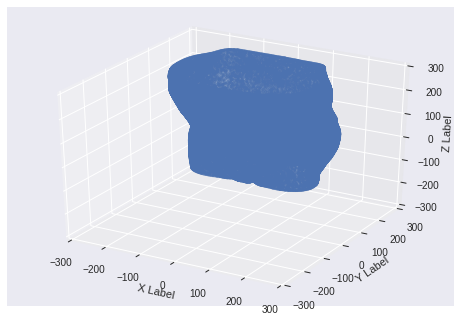

[[  87.3046875    28.71093941 -144.        ]
 [  89.6484375    28.43519974 -144.        ]
 [  91.9921875    28.1594696  -144.        ]
 ...
 [   2.92968798  232.89289856  292.        ]
 [   6.05468798  232.61720276  292.        ]
 [   5.27343798  232.75509644  292.        ]]
Cloud shape: (44180, 3)


In [0]:
plot_ply(body_p)
print(body_p)
print('Cloud shape:', body_p.shape)

We can see a rough outline of the body shape, however it is a bit difficult to understand what it looks like in a 3D space.Let us continue by visualising the other organs for the same patient. 


**The Prostate**

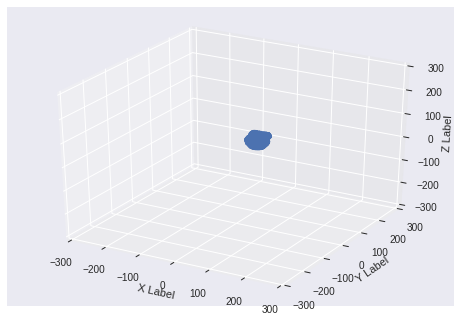

[[ -4.101563 110.7422   -36.29333 ]
 [ -1.757813 113.0859   -36.24657 ]
 [ -4.101563  96.67969  -34.07229 ]
 ...
 [ 18.233    131.8359    20.      ]
 [ 16.99219  133.0768    20.      ]
 [ 16.99219  131.8359    20.13139 ]]
Cloud shape: (1337, 3)


In [0]:
plot_ply(prostate_p)
print(prostate_p)
print('Cloud shape:', prostate_p.shape)

**The rectum**

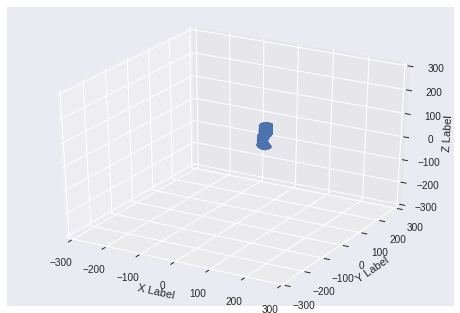

[[ -1.757813 143.5547   -56.18439 ]
 [ -4.101563 145.8984   -56.3268  ]
 [ -1.757813 145.8984   -56.36943 ]
 ...
 [ -6.445313 175.54      36.      ]
 [ -4.101563 175.3418    36.      ]
 [  0.325531 174.0234    36.      ]]
Cloud shape: (1337, 3)


In [0]:
plot_ply(rectum_p)
print(rectum_p)
print('Cloud shape:', prostate_p.shape)

**The femoral heads**

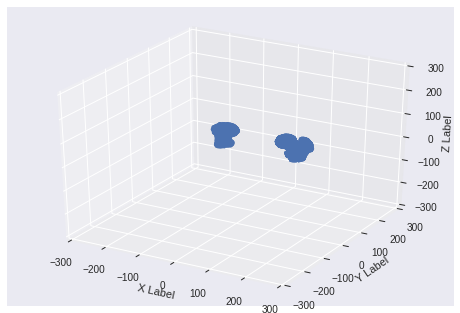

[[101.3672  101.3672  -58.15827]
 [103.7109  101.3672  -58.15827]
 [ 99.02344 103.7109  -58.28188]
 ...
 [-83.78906 115.4297   40.17143]
 [-81.44531 115.8433   40.     ]
 [-88.47656 117.7734   40.     ]]
Cloud shape: (4513, 3)


In [0]:
plot_ply(femH_p)
print(femH_p)
print('Cloud shape:', femH_p.shape)

**The bladder**

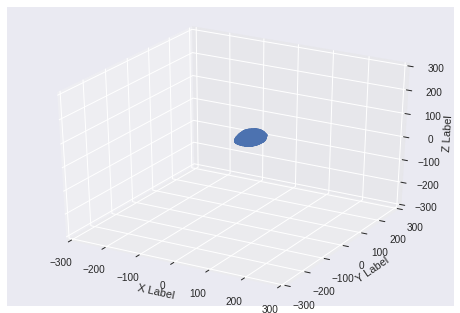

[[-6.445313e+00  6.621094e+01 -7.519531e-02]
 [-4.101563e+00  6.621094e+01 -1.449280e-01]
 [-1.757813e+00  6.621094e+01 -1.714325e-01]
 ...
 [ 2.929688e+00  9.433594e+01  4.610370e+01]
 [-1.757813e+00  9.755859e+01  4.600000e+01]
 [-1.757813e+00  9.667969e+01  4.608955e+01]]
Cloud shape: (1576, 3)


In [0]:
plot_ply(bladder_p)
print(bladder_p)
print('Cloud shape:', bladder_p.shape)

**Combine all of the organs (except for the body) and plot it. **

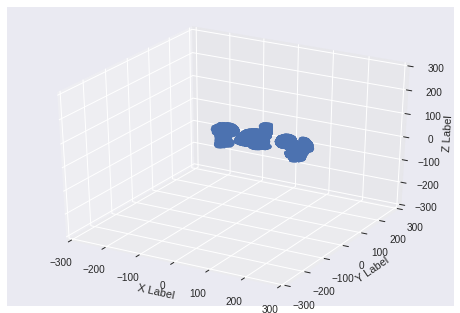

[[-6.445313e+00  6.621094e+01 -7.519531e-02]
 [-4.101563e+00  6.621094e+01 -1.449280e-01]
 [-1.757813e+00  6.621094e+01 -1.714325e-01]
 ...
 [-6.445313e+00  1.755400e+02  3.600000e+01]
 [-4.101563e+00  1.753418e+02  3.600000e+01]
 [ 3.255310e-01  1.740234e+02  3.600000e+01]]
Cloud shape: (8483, 3)


In [0]:
combined_p = np.concatenate((bladder_p, prostate_p, femL_p, femR_p, rectum_p))
plot_ply(combined_p)
print(combined_p)
print('Cloud shape:', combined_p.shape)

We cannot really get a good 3D view of our point clouds, so lets try a more interactive method through jupyter notebook.

### 3.4. Interactive 3D visualisation with Plotly (Jupyter Notebook only)

In [0]:
configure_plotly_browser_state()
init_notebook_mode(connected=False)

X=combined_p[:,0]
Y=combined_p[:,1]
Z=combined_p[:,2]

trace1 = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', 
                      marker=dict(size=10, color=Z, colorscale='Viridis', opacity=0.1))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Prostate, Bladder, Rectum, Femoral Heads Combined")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### 3.5. Combine all point clouds for the given patient (x,y,z points as np.array).

In [0]:
entire_p = np.concatenate((combined_p, body_p))

In [0]:
configure_plotly_browser_state()
init_notebook_mode(connected=False)

X=entire_p[:,0]
Y=entire_p[:,1]
Z=entire_p[:,2]

trace1 = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', 
                      marker=dict(size=0.5, color=Z, colorscale='Viridis', opacity=0.9))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "All Organs")
fig = go.Figure(data=data, layout=layout)
iplot(fig)
print('Entire points combined shape:', entire_p.shape)

Comparison with pre-combined file in MeshLab (direct '.ply' read and plot).

In [0]:
configure_plotly_browser_state()
init_notebook_mode(connected=False)

pre_combined = read_point_cloud("../2_pipeline/combined.ply")
pre_combined_p = np.asarray(pre_combined.points)

X=pre_combined_p[:,0]
Y=pre_combined_p[:,1]
Z=pre_combined_p[:,2]

trace1 = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', 
                      marker=dict(size=0.5, color=Z, colorscale='Viridis', opacity=0.9))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Precombined Organs Using 3rd Party Software (MeshLab)")
fig = go.Figure(data=data, layout=layout)
iplot(fig)
print('Pre-combined points shape:', pre_combined_p.shape)

In [0]:
#differences in shapes
entire_p.shape == pre_combined_p.shape

print(entire_p.shape)
print(pre_combined_p.shape)

print('The difference between the two are', (entire_p.shape[0] - pre_combined_p.shape[0]), "points.")

(52663, 3)
(52632, 3)
The difference between the two are 31 points.


The body ply contains over 44,000 points, is that necessary? Yes! Because excess skin can actually lead to plan violations due to too much radiation.


### 3.6. PointNet Number of Points

The PointNet architecture received k points for each sample (1024 points per object being classified). In order to obtain similar results we need to find a way to downsample the number of points for each of our images to k points. 

#### Create a way to downsample n points to k desired points
Luckily we can use Farthest Point Sampling to do so. Here is the code. 

In [0]:
# farthest point calculation
def calc_distances(p0, points):
    return ((p0 - points)**2).sum(axis=1)

def downsample(pts, K):
    farthest_pts = np.zeros((K, 3))
    farthest_pts[0] = pts[np.random.randint(len(pts))]
    distances = calc_distances(farthest_pts[0], pts)
    for i in range(1, K):
        farthest_pts[i] = pts[np.argmax(distances)]
        distances = np.minimum(distances, calc_distances(farthest_pts[i], pts))
    return farthest_pts

Now lets test it. This is the downsampled image. 

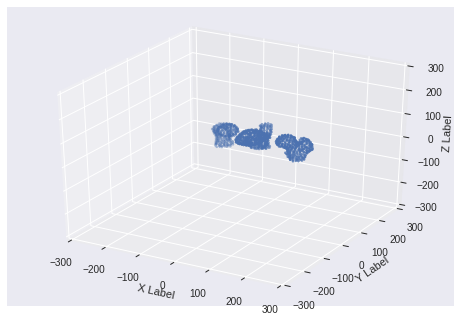

In [0]:
combined_d = downsample(combined_p, 1024)
plot_ply(combined_d)

Compared to the original...

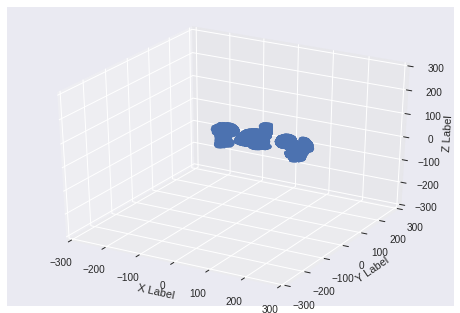

In [0]:
plot_ply(combined_p)

Looks exactly the same. Now lets view the interactive 3D downsampled image.

In [0]:
configure_plotly_browser_state()
init_notebook_mode(connected=False)

X=combined_d[:,0]
Y=combined_d[:,1]
Z=combined_d[:,2]

trace1 = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', 
                      marker=dict(size=10, color=Z, colorscale='Viridis', opacity=0.1))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Downsampled Organs")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Cool, now lets try it on the entire body.

In [0]:
configure_plotly_browser_state()
init_notebook_mode(connected=False)

entire_d = downsample(entire_p, 1024)

X=entire_d[:,0]
Y=entire_d[:,1]
Z=entire_d[:,2]

trace1 = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', 
                      marker=dict(size=10, color=Z, colorscale='Viridis', opacity=0.1))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "All Organs: 1024 Points")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In comparison to the original 52k points, it looks a bit fuzzy. We can try more points to see if there is a better representation. 

In [0]:
configure_plotly_browser_state()
init_notebook_mode(connected=False)

# Downsample with double the points
entire_d = downsample(entire_p, 2048)

X=entire_d[:,0]
Y=entire_d[:,1]
Z=entire_d[:,2]

trace1 = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', 
                      marker=dict(size=10, color=Z, colorscale='Viridis', opacity=0.1))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "All Organs 2048 Points")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

How much information is lost? I am not sure. We should compare this in the PointNet model (high number of points vs low number of points). 

### 3.7. Preprocessing The Data

All of the files we are are stored in a folder with multiple files per patient (IMAGE OF FILES).  What we need to do is create a function that can scan the entire folder, combine all of the points for a given patient and combine them into one, such that each row is for a given patient. The array will have the shape (n, number of points, 3). Where n is the number of patients and each row corresponds to a patient, number of points is the maximum number of points for all possible combined scans (once downsampled), and 3 represents the cartesian (x,y,z) coordinates of each point. 

In [0]:
def max_point_calculator(max_num_only="y", ignore_body="y"):
    """
    This will read the file directory, list all files, find the patient numbers
    Then for a given patient, load all of their files and save the number of points
    into an array of shape (ID, number of points) with a length the number of patients
    """
    # dependencies
    import glob
    import os
    from open3d import read_point_cloud
    import numpy as np
    import re
    os.chdir('../0_data/prostate-no-nodes')
    # This will read the file directory, list all files, find the patient numbers
    # Then for a given patient, load all of their files and merge them into an array
    # File directory is current
    path = '.'
    files = os.listdir(path)  # lists all files in the current directory
    pt_num = []
    for file in files:
        regex = re.compile(r'\d+')
        # for each file extract the number which corresponds to a patient
        for x in regex.findall(file):
            number = int(x)
            pt_num.append(number)
    # turn that list into a set such that each item in the list is now a patient
    pt_nums = set(pt_num)
    pt_nums = [i for i in pt_nums]
    
    ############################################################################
    # Phase 2
    
    # Create place holder for patient name and number of points for that patient
    points_per_patient = np.ndarray(shape=(len(pt_nums),2))
    
    # Create loop 
    for count, patient in enumerate(pt_nums):
        # Instead of this, lets get a list of the file names and then iterate and scan
        patient_files = glob.glob('Mesh_PtNum-' + str(patient) + '*.ply')  # 5433
        
        # create a list to put our points per file in
        temp = []
        for file in patient_files:
            if ignore_body=="y":
                
                if file != 'Mesh_PtNum-' + str(patient) + '-BODY.ply':
                    tmp = read_point_cloud(file)
                    tmp = np.asarray(tmp.points)
                    temp.append(tmp)
            else:
                tmp = read_point_cloud(file)
                tmp = np.asarray(tmp.points)
                temp.append(tmp)
                    

        all_points = np.vstack(temp)
        points_per_patient[count,0] = patient # column 1 is the current patient
        points_per_patient[count,1] = len(all_points) # column 2 is the number of points
        # print("Patient ", patient, "has ", len(all_points), "points.")
    # Change the directory back to local 
    os.chdir('../../1_code')
    
    max_num_points = int(min(points_per_patient[:,1]))
    print("The lowest number of points you can use is: ",max_num_points )
    
    if max_num_only == "y":
        return max_num_points
    else:
        return max_num_points, points_per_patient

Lets find the max number of points that we can use for our downsampling function (this will take a while).

In [0]:
#max_num_points, points_per_patient = max_point_calculator(max_num_only="n", ignore_body="y")

Now that the point information lets have a look at the output.

In [0]:
#max_num_points

We know now that for the files in prostate-no-nodes, the maximum number of points we can specify is 27666. If we wanted to know what patient that corresponds to, we can do so via the 'where' function from numpy

In [0]:
#np.where(points_per_patient[:,1]==27666)

In [0]:
#points_per_patient[123]

We can see that patient 4011 has the lowest number of points of all patients. 

In [0]:
def import_data(folder, name, points_per_sample):
    """
    This will read the file directory, list all files, find the patient numbers
    Then for a given patient, load all of their files and merge them into an array
    """
    # dependencies
    import glob
    import os
    import data_prep
    from open3d import read_point_cloud
    import numpy as np
    import re
    os.chdir('../0_data/' + folder)
    # This will read the file directory, list all files, find the patient numbers
    # Then for a given patient, load all of their files and merge them into an array
    # File directory is current
    path = '.'
    files = os.listdir(path)  # lists all files in the current directory
    pt_num = []
    for file in files:
        regex = re.compile(r'\d+')
        # for each file extract the number which corresponds to a patient
        for x in regex.findall(file):
            number = int(x)
            pt_num.append(number)
    # turn that list into a set such that each item in the list is now a patient
    pt_nums = set(pt_num)
    pt_nums = [i for i in pt_nums]
    all_patients = np.ndarray(shape=(len(pt_nums), points_per_sample, 3))
    
    print("Importing...")
    for count, patient in enumerate(pt_nums):
        # Instead of this, lets get a list of the file names and then iterate and scan
        patient_files = glob.glob('Mesh_PtNum-' + str(patient) + '*.ply')  # 5433
        
        # create a list to put our points per file in
        temp = []
        for file in patient_files:
            
            if file != 'Mesh_PtNum-' + str(patient) + '-BODY.ply':
                tmp = read_point_cloud(file)
                tmp = np.asarray(tmp.points)
                temp.append(tmp)

        all_points = np.vstack(temp)
        downsampled = data_prep.downsample(all_points, points_per_sample)
        all_patients[count] = downsampled
    
    print("Saving...")
    np.save('../../2_pipeline/' + name + '.npy', all_patients)
    np.save('../../2_pipeline/' + name + '-order.npy', pt_nums)
    
    os.chdir('../../1_code')
    print("Done!")
    
    return all_patients, pt_nums

Now we can easily create '.npy' files to load and save the data to. This way, if we wish to run our model again, we do not need to preprocess the data, just simply load the .npy file. The data will be saved in the 2_pipeline folder. Lets scan the data for the patients, combine them and save it as a numpy file (this will take a long while).

In [0]:
# Load data and save it in the pipeline folder.
#prostate_no_nodes, no_nodes_order = import_data(points_per_sample = 4096, name='no-body-4096', folder='prostate-no-nodes')

### 3.8. Loading the data

Now we can load the data that is readily available for our model!

In [0]:
#data_points = np.load('../2_pipeline/prostate-no-nodes-27666.npy')
data_points = np.load('../2_pipeline/no-body-4096.npy')

We can check the shape to see if all ended well with the import function. 

In [0]:
data_points.shape

(286, 4096, 3)

In [0]:
configure_plotly_browser_state()
init_notebook_mode(connected=False)

# Downsample with double the points
test = data_points[0]

# Plot
trace1 = go.Scatter3d(x=test[:,0], y=test[:,1], z=test[:,2], mode='markers', 
                      marker=dict(size=10, color=test[:,2], colorscale='Viridis', opacity=0.1))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Data Check")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

We can do a quick check to see if everything has loaded properly. 

## Define number of points for model

In [0]:
def downsample_dataset(data, desired_points):
    # Create placeholder for points
    downsampled_dataset = np.ndarray(shape=(data.shape[0], desired_points,3))
    
    for i in range(data.shape[0]):
        downsampled_dataset[i] = downsample(data[i], desired_points)
    
    return downsampled_dataset

Now we downsample the point clouds to a desired amount and save in case we wish to use it later or compare across to other sizes.

The other issue we need to worry about is making sure our labels are in the correct order. What I decided to do was save the order of the patients (defualt setting of the import_data function). This way, we can match the corresponding label based on the patient order so that our labels are correct. 

In [0]:
# Load order of patients
no_nodes_order = np.load('../2_pipeline/prostate-no-nodes-order.npy') # y-pre

# Turn into a dataframe to merge with label data and give it the same column name
no_nodes_order = pd.DataFrame(no_nodes_order)
no_nodes_order.columns=["ID"]

# Check
no_nodes_order.head()

,ID
0,3584
1,7169
2,3072
3,5123
4,5120


Now we just need to link the patient number to its given label. 

## 5.  Labels
Our labels are saved in an ''.xlxs' file. What I did before hand, was remove the first few columns which had information about criterias (IMAGE) such that each row now corresponded to a patient. I then saved this as a '.csv' file in the pipeline folder called 'labels_n.csv'. Lets load this data as a Pandas DataFrame in order to match the labels with the patient order for the point clouds. 

In [0]:
labels = pd.read_csv("../2_pipeline/labels_n.csv")

In [0]:
# Visualise
labels.head()

,Bladder ANY,Bladder #,Rectum ANY,Bladder #.1,Bla/Rec ANY,Group,ID,Drx(Gy),Bladder ~ Vol(cc),Bladder ~ D2cc(%),...,Rectum ~ Vol(cc),Rectum ~ D2cc(%),Rectum D2cc MINOR violation,Rectum D2cc MAJOR violation,Rectum ~ V40Gy(%),Rectum V40 MINOR violation,Rectum V40 MAJOR violation,Rectum ~ V65Gy(%),Rectum V65 MINOR violation,Rectum V65 MAJOR violation
0,1.0,1.0,NaN,0.0,1.0,2. pro def with LNs,1358.0,80.0,340.1,103.579427,...,64.6,102.158704,NaN,NaN,34.28969,NaN,NaN,16.798680,NaN,NaN
1,1.0,1.0,NaN,0.0,1.0,2. pro def with LNs,1434.0,80.0,164.0,103.312576,...,69.8,88.447759,NaN,NaN,33.47668,NaN,NaN,5.791384,NaN,NaN
2,NaN,0.0,NaN,0.0,NaN,1. pro def no nodes,1455.0,80.0,146.8,103.925581,...,51.8,98.162577,NaN,NaN,24.65289,NaN,NaN,9.286140,NaN,NaN
3,NaN,0.0,NaN,0.0,NaN,1. pro def no nodes,1567.0,80.0,244.7,103.987786,...,91.4,97.056049,NaN,NaN,25.56651,NaN,NaN,7.138537,NaN,NaN
4,NaN,0.0,NaN,0.0,NaN,1. pro def no nodes,1571.0,80.0,269.2,103.748526,...,81.0,100.271032,NaN,NaN,34.93586,NaN,NaN,15.473620,NaN,NaN


Because we are interested in those without lymph node treatment (for now), let's select those first.

In [0]:
selection = labels.loc[labels['Group'] == '1. pro def no nodes']

In [0]:
selection.shape

(286, 28)

In [0]:
bladders, rectums = selection['Bladder ANY'], selection['Rectum ANY']

In [0]:
bladders.sum()

20.0

In [0]:
rectums.sum()

77.0

## 5.1. Simple Labels (Violation / No Violation)
We need to match the labels to the loaded data based on patient number (ID).

In [0]:
violations = selection[['ID', 'Bla/Rec ANY']].copy()
violations = violations.fillna(0)
violations = violations.rename(columns={'Bla/Rec ANY':'violation'})
violations.astype('int64')

# Merge 2 lists based on column values (matching violation to patient based on order)
labelzz = pd.merge(no_nodes_order, violations, on='ID')
# just get the violations in the same order
y = labelzz[['violation']].values
#turn the list of lists into just one list of 0/1 values
y = [item for sublist in y for item in sublist]
y = np.array(y)

# save labels
# np.save('../2_pipeline/labels.npy', y)

## Pre-Processing

### Model 2: (n,1024,4) - x,y,z,l model.

In [0]:
import numpy as np

# farthest point calculation
def calc_distances(p0, points):
    return ((p0 - points)**2).sum(axis=1)

def downsample(pts, K):
    farthest_pts = np.zeros((K, 3))
    farthest_pts[0] = pts[np.random.randint(len(pts))]
    distances = calc_distances(farthest_pts[0], pts)
    for i in range(1, K):
        farthest_pts[i] = pts[np.argmax(distances)]
        distances = np.minimum(distances, calc_distances(farthest_pts[i], pts))
    return farthest_pts

# Re-download model that enters another column that specifies if point is PTVHD
def import_data_xyzl(folder, name, points_per_sample):
    """
    This will read the file directory, list all files, find the patient numbers
    Then for a given patient, load all of their files and merge them into an array
    """
    # dependencies
    import glob
    import os
    import data_prep
    from open3d import read_point_cloud
    import numpy as np
    import re
    os.chdir('../../1_code')
    os.chdir('../0_data/' + folder)
    # This will read the file directory, list all files, find the patient numbers
    # Then for a given patient, load all of their files and merge them into an array
    # File directory is current
    path = '.'
    files = os.listdir(path)  # lists all files in the current directory
    pt_num = []
    for file in files:
        regex = re.compile(r'\d+')
        # for each file extract the number which corresponds to a patient
        for x in regex.findall(file):
            number = int(x)
            pt_num.append(number)
    # turn that list into a set such that each item in the list is now a patient
    pt_nums = set(pt_num)
    pt_nums = [i for i in pt_nums]
    all_patients = np.ndarray(shape=(len(pt_nums), int(points_per_sample/5)*5, 4))
    ############################################################################
    
    number_of_organs=6
    for count, patient in enumerate(pt_nums):
        
        print('Importing patient ', patient)
        # Read ply files to point cloud format
        prostate = read_point_cloud('Mesh_PtNum-' + str(patient) + '-PTVHD.ply')
        bladder = read_point_cloud('Mesh_PtNum-' + str(patient) + '-Bladder.ply')
        feml = read_point_cloud('Mesh_PtNum-' + str(patient) + '-FemoralHeadL.ply')
        femr = read_point_cloud('Mesh_PtNum-' + str(patient) + '-FemoralHeadR.ply')
        rectum = read_point_cloud('Mesh_PtNum-' + str(patient) + '-Rectum.ply')
        body = read_point_cloud('Mesh_PtNum-' + str(patient) + '-BODY.ply')

        # Convert point cloud format to cartesian coordinates
        prostate = np.asarray(prostate.points)
        bladder = np.asarray(bladder.points)
        feml = np.asarray(feml.points)
        femr = np.asarray(femr.points)
        rectum = np.asarray(rectum.points)
        body = np.asarray(body.points)
        
        # downsample point cloud
        prostate = downsample(prostate, int(points_per_sample/number_of_organs))
        bladder = downsample(bladder, int(points_per_sample/number_of_organs))
        feml = downsample(feml, int(points_per_sample/number_of_organs))
        femr = downsample(femr, int(points_per_sample/number_of_organs))
        rectum = downsample(rectum, int(points_per_sample/number_of_organs))
        body = downsample(body, int(points_per_sample/number_of_organs))
        
        # Add dimension to signify that prostate is target
        prostate=np.insert(prostate, 3, 1, axis=1)
        bladder=np.insert(bladder, 3, 0, axis=1)
        feml=np.insert(feml, 3, 0, axis=1)
        femr=np.insert(femr, 3, 0, axis=1)
        rectum=np.insert(rectum, 3, 0, axis=1)
        body=np.insert(body, 3, 0, axis=1)
        
        # Combine them 
        combined = np.concatenate((prostate,bladder,feml,femr,rectum, body))
        # combined will have shape = (p, 4) where 4 is x,y,z,l

        # add downsampled and labelled patient to all patients array
        all_patients[count] = combined
    
    print("Saving...")
    np.save('../../2_pipeline/' + name + '.npy', all_patients)
    np.save('../../2_pipeline/' + name + '-order.npy', pt_nums)
    
    os.chdir('../../1_code')
    print("Done!")
    
    return all_patients, pt_nums

In [22]:
dataset, ptnums = import_data_xyzl(folder='prostate-no-nodes', name='1024-xyzl-body', points_per_sample=1024)

Importing patient  3584
Importing patient  7169
Importing patient  3072
Importing patient  5123
Importing patient  5120
Importing patient  3081
Importing patient  6156
Importing patient  3596
Importing patient  4111
Importing patient  4113
Importing patient  3602
Importing patient  7185
Importing patient  4630
Importing patient  5654
Importing patient  2073
Importing patient  7195
Importing patient  2076
Importing patient  6174
Importing patient  1567
Importing patient  4128
Importing patient  1571
Importing patient  7204
Importing patient  6180
Importing patient  6693
Importing patient  5159
Importing patient  3623
Importing patient  7210
Importing patient  3627
Importing patient  3628
Importing patient  1581
Importing patient  5674
Importing patient  4657
Importing patient  5169
Importing patient  4658
Importing patient  6198
Importing patient  3134
Importing patient  3647
Importing patient  1600
Importing patient  2113
Importing patient  4162
Importing patient  3646
Importing patien

ValueError: ignored

### Model 3: 4D data (n,1024,3,2)

In [0]:
# Re-download model that enters another column that specifies if point is PTVHD
def import_data_4D(folder, name, points_per_sample):
    """
    This will read the file directory, list all files, find the patient numbers
    Then for a given patient, load all of their files and merge them into an array
    """
    # dependencies
    import glob
    import os
    import data_prep
    from open3d import read_point_cloud
    import numpy as np
    import re
    os.chdir('../0_data/' + folder)
    # This will read the file directory, list all files, find the patient numbers
    # Then for a given patient, load all of their files and merge them into an array
    # File directory is current
    path = '.'
    files = os.listdir(path)  # lists all files in the current directory
    pt_num = []
    for file in files:
        regex = re.compile(r'\d+')
        # for each file extract the number which corresponds to a patient
        for x in regex.findall(file):
            number = int(x)
            pt_num.append(number)
    # turn that list into a set such that each item in the list is now a patient
    pt_nums = set(pt_num)
    pt_nums = [i for i in pt_nums]
    all_patients = np.ndarray(shape=(len(pt_nums), int(points_per_sample/5)*5, 3, 3))
    ############################################################################
    
    for count, patient in enumerate(pt_nums):
        
        print('Importing patient ', patient)
        # 1.Read ply files to point cloud format
        prostate = read_point_cloud('Mesh_PtNum-' + str(patient) + '-PTVHD.ply')
        bladder = read_point_cloud('Mesh_PtNum-' + str(patient) + '-Bladder.ply')
        feml = read_point_cloud('Mesh_PtNum-' + str(patient) + '-FemoralHeadL.ply')
        femr = read_point_cloud('Mesh_PtNum-' + str(patient) + '-FemoralHeadR.ply')
        rectum = read_point_cloud('Mesh_PtNum-' + str(patient) + '-Rectum.ply')
        # body = read_point_cloud('Mesh_PtNum-' + str(patient) + '-BODY.ply')

        # 2.Convert point cloud format to cartesian coordinates
        prostate = np.asarray(prostate.points)
        bladder = np.asarray(bladder.points)
        feml = np.asarray(feml.points)
        femr = np.asarray(femr.points)
        rectum = np.asarray(rectum.points)
        # body = np.asarray(body.points)
        
        # 3.Downsample point cloud
        points_per_organ = int(points_per_sample/5)
        prostate = downsample(prostate, points_per_organ)
        bladder = downsample(bladder, points_per_organ)
        feml = downsample(feml, points_per_organ)
        femr = downsample(femr, points_per_organ)
        rectum = downsample(rectum, points_per_organ)
        # body = downsample(body, int(points_per_sample/6))
        
        # 4.Add dimension to signify that prostate is target
        
        # 4.1 Create 4D placeholder
        prostate_coloured = np.ndarray((points_per_organ, 3, 3))
        bladder_coloured = np.ndarray((points_per_organ, 3, 3))
        rectum_coloured = np.ndarray((points_per_organ, 3, 3))
        feml_coloured = np.ndarray((points_per_organ, 3, 3))
        femr_coloured = np.ndarray((points_per_organ, 3, 3))
        # body_coloured = np.ndarray((points_per_organ, 3, 3))
        
        # Create function that adds colour dimension to data
        from matplotlib.pyplot import cm

        # Target volume is red
        def add_rgb_prostate(array):
            scaler_map = cm.ScalarMappable(cmap="Reds")
            array = scaler_map.to_rgba(array)[:, : -1]
            return array
        # Add red to prostate and enter to placeholder
        for i in range(prostate.shape[0]):
            prostate_coloured[i] = add_rgb_prostate(prostate[i])

        # Other organs are blue and entered to placeholder
        def add_rgb_organs(array):
            scaler_map = cm.ScalarMappable(cmap="Blues")
            array = scaler_map.to_rgba(array)[:, : -1]
            return array
        # Add blue to other organs
        for i in range(prostate.shape[0]):
            bladder_coloured[i] = add_rgb_organs(bladder[i])
            rectum_coloured[i] = add_rgb_organs(rectum[i])
            feml_coloured[i] = add_rgb_organs(feml[i])
            femr_coloured[i] = add_rgb_organs(femr[i])
            # body_coloured[i] = add_rgb_prostate(prostate[i])
        
        # 5.Combine them 
        combined = np.concatenate((prostate_coloured,bladder_coloured,feml_coloured,femr_coloured,rectum_coloured))
        
        # 6.Add downsampled and labelled patient to all patients array
        all_patients[count] = combined
    
    print("Saving...")
    np.save('../../2_pipeline/' + name + '-4D.npy', all_patients)
    np.save('../../2_pipeline/' + name + '-4D-order.npy', pt_nums)
    
    os.chdir('../../1_code')
    print("Done!")
    
    return all_patients, pt_nums

In [0]:
#dataset, ptnums = import_data_4D(folder='prostate-no-nodes', name='2048', points_per_sample=2048)